In [1]:
import numpy as np
import pandas as pd

In [2]:
AROMA = ['A_malt_all', 'A_malt_grain', 'A_malt_bread', 'A_malt_cara',
'A_malt_burn', 'A_hops_all', 'A_hops_citrus', 'A_hops_tropical',
'A_hops_noble', 'A_hops_woody', 'A_esters_all', 'A_esters_ethac',
'A_esters_isoaa', 'A_esters_flower', 'A_esters_fruity']

FLAVOUR = ['F_malt_all', 'F_malt_grain', 'F_malt_bread', 'F_malt_cara',
'F_malt_burn', 'F_hops_all', 'F_hops_citrus', 'F_hops_tropical',
'F_hops_noble', 'F_hops_woody', 'F_esters_all', 'F_esters_ethac',
'F_esters_isoaa', 'F_esters_flower', 'F_esters_fruity']

BOTH = ['A_malt_all', 'A_malt_grain', 'A_malt_bread', 'A_malt_cara',
'A_malt_burn', 'A_hops_all', 'A_hops_citrus', 'A_hops_tropical',
'A_hops_noble', 'A_hops_woody', 'A_esters_all', 'A_esters_ethac',
'A_esters_isoaa', 'A_esters_flower', 'A_esters_fruity', 'F_malt_all',
'F_malt_grain', 'F_malt_bread', 'F_malt_cara', 'F_malt_burn',
'F_hops_all', 'F_hops_citrus', 'F_hops_tropical', 'F_hops_noble',
'F_hops_woody', 'F_esters_all', 'F_esters_ethac', 'F_esters_isoaa',
'F_esters_flower', 'F_esters_fruity']

REST = ['acidity', 'bitternes','sweetness', 'X4vg', 'diacetyl', 'dms',
'metallic', 'stale_hops', 't2n', 'orange', 'coriander', 'clove', 'lactic',
'acetic', 'barnyard', 'alcohol', 'aftertaste', 'body', 'co2', 'overall']

ALL = ['A_malt_all', 'A_malt_grain', 'A_malt_bread', 'A_malt_cara',
'A_malt_burn', 'A_hops_all', 'A_hops_citrus', 'A_hops_tropical',
'A_hops_noble', 'A_hops_woody', 'A_esters_all', 'A_esters_ethac',
'A_esters_isoaa', 'A_esters_flower', 'A_esters_fruity', 'F_malt_all',
'F_malt_grain', 'F_malt_bread', 'F_malt_cara', 'F_malt_burn',
'F_hops_all', 'F_hops_citrus', 'F_hops_tropical', 'F_hops_noble',
'F_hops_woody', 'F_esters_all', 'F_esters_ethac', 'F_esters_isoaa',
'F_esters_flower', 'F_esters_fruity', 'acidity', 'bitternes',
'sweetness', 'X4vg', 'diacetyl', 'dms', 'metallic', 'stale_hops', 't2n',
'orange', 'coriander', 'clove', 'lactic', 'acetic', 'barnyard',
'alcohol', 'aftertaste', 'body', 'co2', 'overall']

In [21]:
LABEL_COLS = ['overall']

In [109]:
df_train_X = pd.read_csv('../data/beer_strong_pp_features_train.csv', index_col=0)
df_train_y = pd.read_csv('../data/beer_strong_pp_labels_panel_train.csv', index_col=0)[LABEL_COLS]
df_test_X = pd.read_csv('../data/beer_strong_pp_features_test.csv', index_col=0)
df_test_y = pd.read_csv('../data/beer_strong_pp_labels_panel_test.csv', index_col=0)[LABEL_COLS]

df_train_X.shape, df_train_y.shape, df_test_X.shape, df_test_y.shape

((94, 231), (94, 1), (5, 231), (5, 1))

In [110]:
train_X = df_train_X.values
train_y = df_train_y.values
test_X = df_test_X.values
test_y = df_test_y.values

In [111]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from hyperdt.ensemble import HyperbolicRandomForestClassifier as HyperRF
from sklearn.ensemble import RandomForestRegressor as SklearnRF

In [112]:
# Train seperate models on validation splits, make test predictions with each model and compare mean prediction to test set.
# Way better for XBGregressor, consistently within rounding error better or worse for RFregressor
test_preds = []

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_X, train_y)):
    # regressor = xgb.XGBRegressor(tree_method='hist', seed=42)
    regressor = SklearnRF(random_state=42)
    # regressor = HyperRF(random_state=42)
    # for tree in regressor.trees:
    #     tree.skip_hyperboloid_check = True

    fold_train_X, fold_val_X = train_X[train_idx], train_X[val_idx]
    fold_train_y, fold_val_y = train_y[train_idx], train_y[val_idx]

    # Fitting the model
    regressor.fit(fold_train_X, fold_train_y)

    # Predict the model
    pred = regressor.predict(fold_val_X)

    mae = MAE(fold_val_y, pred)
    r2 = r2_score(fold_val_y, pred)
    # ap = AP(fold_val_y, pred)


    print("Mean MAE : % f" % mae)
    print("Mean R-squared : % f" % r2)
    # print("Mean Average Precision : % f" % ap)
    test_preds.append(regressor.predict(test_X))


cum_test_pred = np.mean(test_preds, axis=0)
mae = MAE(test_y, cum_test_pred)
r2 = r2_score(test_y, cum_test_pred)

print()
print("TEST Mean MAE : % f" % mae)
print("TEST Mean R-squared : % f" % r2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean MAE :  0.708686
Mean R-squared :  0.015600


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean MAE :  0.666939
Mean R-squared :  0.122169


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean MAE :  0.686560
Mean R-squared : -0.023705

TEST Mean MAE :  0.687179
TEST Mean R-squared : -0.198898


In [113]:
# Train on all train data, then validate on test set.
test_preds = []

# regressor = xgb.XGBRegressor(tree_method='hist', seed=42)
regressor = SklearnRF(random_state=42)
# regressor = HyperRF(random_state=42)
# for tree in regressor.trees:
#     tree.skip_hyperboloid_check = True

fold_train_X, fold_val_X = train_X, test_X
fold_train_y, fold_val_y = train_y, test_y

# Fitting the model
regressor.fit(fold_train_X, fold_train_y)

# Predict the model
pred = regressor.predict(fold_val_X)

mae = MAE(fold_val_y, pred)
r2 = r2_score(fold_val_y, pred)
# ap = AP(fold_val_y, pred)


print("Mean MAE : % f" % mae)
print("Mean R-squared : % f" % r2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean MAE :  0.644393
Mean R-squared : -0.053700


<h2> All </h2>
XGBregressor:
Mean MAE :  0.638011
Mean R-squared :  0.206903

SklearnRFregressor
Mean MAE :  0.631028
Mean R-squared :  0.245145

<h2> Both </h2>
XGBregressor:
Mean MAE :  0.683563
Mean R-squared :  0.199913

SklearnRFregressor
Mean MAE :  0.670847
Mean R-squared :  0.232012

<h2> Aroma </h2>
XGBregressor:
Mean MAE :  0.694770
Mean R-squared :  0.167947

SklearnRFregressor
Mean MAE :  0.680904
Mean R-squared :  0.206033

<h2> Falvour </h2>
XGBregressor:
Mean MAE :  0.670411
Mean R-squared :  0.230154

SklearnRFregressor
Mean MAE :  0.663148
Mean R-squared :  0.240679

<h2> Overall </h2>
XGBregressor:
Mean MAE :  0.782159
Mean R-squared :  0.106610

SklearnRFregressor
Mean MAE :  0.766449
Mean R-squared :  0.142508

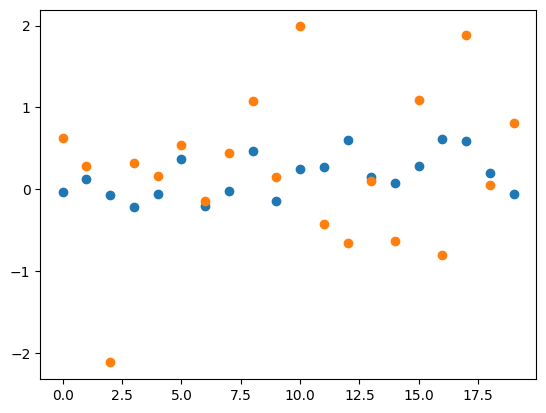

In [96]:
import matplotlib.pyplot as plt

plt.scatter(range(len(pred)), pred)
plt.scatter(range(len(test_y)), test_y)
plt.show()